In [21]:
import glob
import os
import random

import torch
import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
import xml.etree.ElementTree as ET

import torch.nn as nn
import math

import numpy as np
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

import cv2

import time
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Dataset Stuff makign new train, Val folders

In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm

# ---------------- CONFIG ----------------
SRC_ROOT = r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\raw\VOC2012_train_val"
DST_ROOT = r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed"

CLASSES = {"person", "car", "cat", "aeroplane", "bicycle"}

SPLITS = {
    "train": "ImageSets/Main/train.txt",
    "val": "ImageSets/Main/val.txt",
}
# ----------------------------------------


def ensure_dirs(split):
    for d in ["Annotations", "JPEGImages"]:
        os.makedirs(os.path.join(DST_ROOT, f"VOC_{split}", d), exist_ok=True)


def filter_and_copy(img_id, split):
    ann_src = os.path.join(SRC_ROOT, "Annotations", f"{img_id}.xml")
    img_src = os.path.join(SRC_ROOT, "JPEGImages", f"{img_id}.jpg")

    tree = ET.parse(ann_src)
    root = tree.getroot()

    objects = root.findall("object")
    keep_objects = []

    for obj in objects:
        name = obj.find("name").text
        if name in CLASSES:
            keep_objects.append(obj)

    if len(keep_objects) == 0:
        return False  # drop image entirely

    # remove all objects
    for obj in objects:
        root.remove(obj)

    # add back filtered ones
    for obj in keep_objects:
        root.append(obj)

    ann_dst = os.path.join(DST_ROOT, f"VOC_{split}", "Annotations", f"{img_id}.xml")
    img_dst = os.path.join(DST_ROOT, f"VOC_{split}", "JPEGImages", f"{img_id}.jpg")

    tree.write(ann_dst)
    shutil.copyfile(img_src, img_dst)

    return True


def process_split(split, split_file):
    ensure_dirs(split)

    split_path = os.path.join(SRC_ROOT, split_file)
    with open(split_path) as f:
        img_ids = [line.strip() for line in f.readlines()]

    kept = 0
    for img_id in tqdm(img_ids, desc=f"Processing {split}"):
        if filter_and_copy(img_id, split):
            kept += 1

    print(f"{split.upper()}: kept {kept}/{len(img_ids)} images")


if __name__ == "__main__":
    for split, split_file in SPLITS.items():
        process_split(split, split_file)


Processing train: 100%|██████████████████████████████████████████████████████████| 5717/5717 [00:05<00:00, 1117.20it/s]


TRAIN: kept 3377/5717 images


Processing val: 100%|████████████████████████████████████████████████████████████| 5823/5823 [00:05<00:00, 1137.01it/s]

VAL: kept 3458/5823 images


# VOC

In [94]:
def load_images_and_anns(im_dir, ann_dir, label2idx):
    
    im_infos = []
    for ann_file in tqdm(glob.glob(os.path.join(ann_dir, '*.xml'))):
        im_info = {}
        im_info['img_id'] = os.path.basename(ann_file).split('.xml')[0]
        im_info['filename'] = os.path.join(im_dir, '{}.jpg'.format(im_info['img_id']))
        ann_info = ET.parse(ann_file)
        root = ann_info.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        im_info['width'] = width
        im_info['height'] = height
        detections = []
        
        for obj in ann_info.findall('object'):
            det = {}
            
            #label = label2idx[obj.find('name').text]
            cls_name = obj.find('name').text
            if cls_name not in label2idx:
                continue
            label = label2idx[cls_name]

            
            bbox_info = obj.find('bndbox')
            bbox = [
                int(float(bbox_info.find('xmin').text))-1,
                int(float(bbox_info.find('ymin').text))-1,
                int(float(bbox_info.find('xmax').text))-1,
                int(float(bbox_info.find('ymax').text))-1
            ]
            det['label'] = label
            det['bbox'] = bbox
            detections.append(det)
        if len(detections) == 0:
            print("no det")
            continue
        
        im_info['detections'] = detections
        im_infos.append(im_info)
    print('Total {} images found'.format(len(im_infos)))
    return im_infos


class VOCDataset(Dataset):
    def __init__(self, split, im_dir, ann_dir):
        self.split = split
        self.im_dir = im_dir
        self.ann_dir = ann_dir
        classes = ['person', 'car', 'cat', 'aeroplane', 'bicycle']
        
        classes = sorted(classes)
        classes = ['background'] + classes
        self.label2idx = {classes[idx]: idx for idx in range(len(classes))}
        self.idx2label = {idx: classes[idx] for idx in range(len(classes))}
        print(self.idx2label)
        self.images_info = load_images_and_anns(im_dir, ann_dir, self.label2idx)
    
    def __len__(self):
        return len(self.images_info)
    
    def __getitem__(self, index):
        im_info = self.images_info[index]
        im = Image.open(im_info['filename']).convert("RGB")
    
        to_flip = False
    
        if self.split == 'train':
            # Random Horizontal Flip
            if random.random() < 0.5:
                to_flip = True
                im = im.transpose(Image.FLIP_LEFT_RIGHT)
    
            # Color Jitter (includes brightness + saturation jitter)
            im = torchvision.transforms.ColorJitter(
                brightness=0.2,
                contrast=0.0,
                saturation=0.2,
                hue=0.0
            )(im)
    
            # Gaussian Blur (low probability)
            if random.random() < 0.1:
                im = torchvision.transforms.GaussianBlur(kernel_size=3)(im)
    
        im_tensor = torchvision.transforms.ToTensor()(im)
    
        targets = {}
        targets['bboxes'] = torch.as_tensor(
            [detection['bbox'] for detection in im_info['detections']],
            dtype=torch.float32
        )
        targets['labels'] = torch.as_tensor(
            [detection['label'] for detection in im_info['detections']],
            dtype=torch.int64
        )
    
        if to_flip:
            im_w = im_tensor.shape[-1]
            for idx, box in enumerate(targets['bboxes']):
                x1, y1, x2, y2 = box
                w = x2 - x1
                x1 = im_w - x1 - w
                x2 = x1 + w
                targets['bboxes'][idx] = torch.as_tensor([x1, y1, x2, y2])
    
        return im_tensor, targets, im_info['filename']

# fast Rcnn

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def get_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    x_left = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    y_top = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    x_right = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    y_bottom = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    intersection_area = (x_right - x_left).clamp(min=0) * (y_bottom - y_top).clamp(min=0)
    union = area1[:, None] + area2 - intersection_area
    iou = intersection_area / union
    return iou


def boxes_to_transformation_targets(ground_truth_boxes, anchors_or_proposals):
    widths = anchors_or_proposals[:, 2] - anchors_or_proposals[:, 0]
    heights = anchors_or_proposals[:, 3] - anchors_or_proposals[:, 1]
    center_x = anchors_or_proposals[:, 0] + 0.5 * widths
    center_y = anchors_or_proposals[:, 1] + 0.5 * heights

    gt_widths = ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0]
    gt_heights = ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1]
    gt_center_x = ground_truth_boxes[:, 0] + 0.5 * gt_widths
    gt_center_y = ground_truth_boxes[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_center_x - center_x) / widths
    targets_dy = (gt_center_y - center_y) / heights
    targets_dw = torch.log(gt_widths / widths)
    targets_dh = torch.log(gt_heights / heights)
    regression_targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return regression_targets


def apply_regression_pred_to_anchors_or_proposals(box_transform_pred, anchors_or_proposals):
    box_transform_pred = box_transform_pred.reshape(
        box_transform_pred.size(0), -1, 4
    )

    w = anchors_or_proposals[:, 2] - anchors_or_proposals[:, 0]
    h = anchors_or_proposals[:, 3] - anchors_or_proposals[:, 1]
    center_x = anchors_or_proposals[:, 0] + 0.5 * w
    center_y = anchors_or_proposals[:, 1] + 0.5 * h

    dx = box_transform_pred[..., 0]
    dy = box_transform_pred[..., 1]
    dw = box_transform_pred[..., 2]
    dh = box_transform_pred[..., 3]

    dw = torch.clamp(dw, max=math.log(1000.0 / 16))
    dh = torch.clamp(dh, max=math.log(1000.0 / 16))

    pred_center_x = dx * w[:, None] + center_x[:, None]
    pred_center_y = dy * h[:, None] + center_y[:, None]
    pred_w = torch.exp(dw) * w[:, None]
    pred_h = torch.exp(dh) * h[:, None]

    pred_box_x1 = pred_center_x - 0.5 * pred_w
    pred_box_y1 = pred_center_y - 0.5 * pred_h
    pred_box_x2 = pred_center_x + 0.5 * pred_w
    pred_box_y2 = pred_center_y + 0.5 * pred_h

    pred_boxes = torch.stack(
        (pred_box_x1, pred_box_y1, pred_box_x2, pred_box_y2), dim=2
    )
    return pred_boxes


def sample_positive_negative(labels, positive_count, total_count):
    positive = torch.where(labels >= 1)[0]
    negative = torch.where(labels == 0)[0]

    num_pos = min(positive.numel(), positive_count)
    num_neg = min(negative.numel(), total_count - num_pos)

    perm_positive_idxs = torch.randperm(positive.numel(), device=positive.device)[:num_pos]
    perm_negative_idxs = torch.randperm(negative.numel(), device=negative.device)[:num_neg]

    pos_idxs = positive[perm_positive_idxs]
    neg_idxs = negative[perm_negative_idxs]

    sampled_pos_idx_mask = torch.zeros_like(labels, dtype=torch.bool)
    sampled_neg_idx_mask = torch.zeros_like(labels, dtype=torch.bool)

    sampled_pos_idx_mask[pos_idxs] = True
    sampled_neg_idx_mask[neg_idxs] = True

    return sampled_neg_idx_mask, sampled_pos_idx_mask


def clamp_boxes_to_image_boundary(boxes, image_shape):
    boxes_x1 = boxes[..., 0]
    boxes_y1 = boxes[..., 1]
    boxes_x2 = boxes[..., 2]
    boxes_y2 = boxes[..., 3]

    height, width = image_shape[-2:]

    boxes_x1 = boxes_x1.clamp(min=0, max=width)
    boxes_x2 = boxes_x2.clamp(min=0, max=width)
    boxes_y1 = boxes_y1.clamp(min=0, max=height)
    boxes_y2 = boxes_y2.clamp(min=0, max=height)

    boxes = torch.cat(
        (boxes_x1[..., None], boxes_y1[..., None],
         boxes_x2[..., None], boxes_y2[..., None]),
        dim=-1
    )
    return boxes


def transform_boxes_to_original_size(boxes, new_size, original_size):
    ratios = [
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]

    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height

    return torch.stack((xmin, ymin, xmax, ymax), dim=1)


class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels, scales, aspect_ratios, model_config):
        super(RegionProposalNetwork, self).__init__()
        self.scales = scales
        self.low_iou_threshold = model_config['rpn_bg_threshold']
        self.high_iou_threshold = model_config['rpn_fg_threshold']
        self.rpn_nms_threshold = model_config['rpn_nms_threshold']
        self.rpn_batch_size = model_config['rpn_batch_size']
        self.rpn_pos_count = int(model_config['rpn_pos_fraction'] * self.rpn_batch_size)
        self.rpn_topk = model_config['rpn_train_topk'] if self.training else model_config['rpn_test_topk']
        self.rpn_prenms_topk = (
            model_config['rpn_train_prenms_topk']
            if self.training
            else model_config['rpn_test_prenms_topk']
        )
        self.aspect_ratios = aspect_ratios
        self.num_anchors = len(self.scales) * len(self.aspect_ratios)

        self.rpn_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.cls_layer = nn.Conv2d(in_channels, self.num_anchors, kernel_size=1, stride=1)
        self.bbox_reg_layer = nn.Conv2d(in_channels, self.num_anchors * 4, kernel_size=1, stride=1)

        for layer in [self.rpn_conv, self.cls_layer, self.bbox_reg_layer]:
            torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)

    def generate_anchors(self, image, feat):
        grid_h, grid_w = feat.shape[-2:]
        image_h, image_w = image.shape[-2:]

        stride_h = torch.tensor(image_h // grid_h, dtype=torch.int64, device=feat.device)
        stride_w = torch.tensor(image_w // grid_w, dtype=torch.int64, device=feat.device)

        scales = torch.as_tensor(self.scales, dtype=feat.dtype, device=feat.device)
        aspect_ratios = torch.as_tensor(self.aspect_ratios, dtype=feat.dtype, device=feat.device)

        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios

        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)

        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        base_anchors = base_anchors.round()

        shifts_x = torch.arange(0, grid_w, dtype=torch.int32, device=feat.device) * stride_w
        shifts_y = torch.arange(0, grid_h, dtype=torch.int32, device=feat.device) * stride_h

        shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")

        shifts_x = shifts_x.reshape(-1)
        shifts_y = shifts_y.reshape(-1)

        shifts = torch.stack((shifts_x, shifts_y, shifts_x, shifts_y), dim=1)

        anchors = shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)
        anchors = anchors.reshape(-1, 4)
        return anchors

    def assign_targets_to_anchors(self, anchors, gt_boxes):
        iou_matrix = get_iou(gt_boxes, anchors)

        best_match_iou, best_match_gt_idx = iou_matrix.max(dim=0)
        best_match_gt_idx_pre_thresholding = best_match_gt_idx.clone()

        below_low_threshold = best_match_iou < self.low_iou_threshold
        between_thresholds = (best_match_iou >= self.low_iou_threshold) & (
            best_match_iou < self.high_iou_threshold
        )

        best_match_gt_idx[below_low_threshold] = -1
        best_match_gt_idx[between_thresholds] = -2

        best_anchor_iou_for_gt, _ = iou_matrix.max(dim=1)
        gt_pred_pair_with_highest_iou = torch.where(
            iou_matrix == best_anchor_iou_for_gt[:, None]
        )

        pred_inds_to_update = gt_pred_pair_with_highest_iou[1]
        best_match_gt_idx[pred_inds_to_update] = best_match_gt_idx_pre_thresholding[
            pred_inds_to_update
        ]

        matched_gt_boxes = gt_boxes[best_match_gt_idx.clamp(min=0)]

        labels = best_match_gt_idx >= 0
        labels = labels.to(dtype=torch.float32)

        background_anchors = best_match_gt_idx == -1
        labels[background_anchors] = 0.0

        ignored_anchors = best_match_gt_idx == -2
        labels[ignored_anchors] = -1.0

        return labels, matched_gt_boxes

    def filter_proposals(self, proposals, cls_scores, image_shape):
        cls_scores = cls_scores.reshape(-1)
        cls_scores = torch.sigmoid(cls_scores)
        _, top_n_idx = cls_scores.topk(min(self.rpn_prenms_topk, len(cls_scores)))

        cls_scores = cls_scores[top_n_idx]
        proposals = proposals[top_n_idx]

        proposals = clamp_boxes_to_image_boundary(proposals, image_shape)

        min_size = 16
        ws = proposals[:, 2] - proposals[:, 0]
        hs = proposals[:, 3] - proposals[:, 1]
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]

        proposals = proposals[keep]
        cls_scores = cls_scores[keep]

        keep_mask = torch.zeros_like(cls_scores, dtype=torch.bool)
        keep_indices = torch.ops.torchvision.nms(
            proposals, cls_scores, self.rpn_nms_threshold
        )
        keep_mask[keep_indices] = True
        keep_indices = torch.where(keep_mask)[0]

        post_nms_keep_indices = keep_indices[
            cls_scores[keep_indices].sort(descending=True)[1]
        ]

        proposals = proposals[post_nms_keep_indices[: self.rpn_topk]]
        cls_scores = cls_scores[post_nms_keep_indices[: self.rpn_topk]]

        return proposals, cls_scores

    def forward(self, image, feat, target=None):
        rpn_feat = nn.ReLU()(self.rpn_conv(feat))
        cls_scores = self.cls_layer(rpn_feat)
        box_transform_pred = self.bbox_reg_layer(rpn_feat)

        anchors = self.generate_anchors(image, feat)

        number_of_anchors_per_location = cls_scores.size(1)
        cls_scores = cls_scores.permute(0, 2, 3, 1)
        cls_scores = cls_scores.reshape(-1, 1)

        box_transform_pred = box_transform_pred.view(
            box_transform_pred.size(0),
            number_of_anchors_per_location,
            4,
            rpn_feat.shape[-2],
            rpn_feat.shape[-1],
        )
        box_transform_pred = box_transform_pred.permute(0, 3, 4, 1, 2)
        box_transform_pred = box_transform_pred.reshape(-1, 4)

        proposals = apply_regression_pred_to_anchors_or_proposals(
            box_transform_pred.detach().reshape(-1, 1, 4), anchors
        )
        proposals = proposals.reshape(proposals.size(0), 4)

        proposals, scores = self.filter_proposals(
            proposals, cls_scores.detach(), image.shape
        )

        rpn_output = {"proposals": proposals, "scores": scores}

        if not self.training or target is None:
            return rpn_output

        labels_for_anchors, matched_gt_boxes_for_anchors = self.assign_targets_to_anchors(
            anchors, target["bboxes"][0]
        )

        regression_targets = boxes_to_transformation_targets(
            matched_gt_boxes_for_anchors, anchors
        )

        sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(
            labels_for_anchors,
            positive_count=self.rpn_pos_count,
            total_count=self.rpn_batch_size,
        )

        sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]

        localization_loss = (
            torch.nn.functional.smooth_l1_loss(
                box_transform_pred[sampled_pos_idx_mask],
                regression_targets[sampled_pos_idx_mask],
                beta=1 / 9,
                reduction="sum",
            )
            / sampled_idxs.numel()
        )

        cls_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            cls_scores[sampled_idxs].flatten(),
            labels_for_anchors[sampled_idxs].flatten(),
        )

        rpn_output["rpn_classification_loss"] = cls_loss
        rpn_output["rpn_localization_loss"] = localization_loss
        return rpn_output


class ROIHead(nn.Module):
    def __init__(self, model_config, num_classes, in_channels):
        super(ROIHead, self).__init__()
        self.num_classes = num_classes
        self.roi_batch_size = model_config["roi_batch_size"]
        self.roi_pos_count = int(model_config["roi_pos_fraction"] * self.roi_batch_size)
        self.iou_threshold = model_config["roi_iou_threshold"]
        self.low_bg_iou = model_config["roi_low_bg_iou"]
        self.nms_threshold = model_config["roi_nms_threshold"]
        self.topK_detections = model_config["roi_topk_detections"]
        self.low_score_threshold = model_config["roi_score_threshold"]
        self.pool_size = model_config["roi_pool_size"]
        self.fc_inner_dim = model_config["fc_inner_dim"]

        self.fc6 = nn.Linear(in_channels * self.pool_size * self.pool_size, self.fc_inner_dim)
        self.fc7 = nn.Linear(self.fc_inner_dim, self.fc_inner_dim)
        self.cls_layer = nn.Linear(self.fc_inner_dim, self.num_classes)
        self.bbox_reg_layer = nn.Linear(self.fc_inner_dim, self.num_classes * 4)

        torch.nn.init.normal_(self.cls_layer.weight, std=0.01)
        torch.nn.init.constant_(self.cls_layer.bias, 0)
        torch.nn.init.normal_(self.bbox_reg_layer.weight, std=0.001)
        torch.nn.init.constant_(self.bbox_reg_layer.bias, 0)

    def assign_target_to_proposals(self, proposals, gt_boxes, gt_labels):
        iou_matrix = get_iou(gt_boxes, proposals)
        best_match_iou, best_match_gt_idx = iou_matrix.max(dim=0)

        background_proposals = (best_match_iou < self.iou_threshold) & (
            best_match_iou >= self.low_bg_iou
        )
        ignored_proposals = best_match_iou < self.low_bg_iou

        best_match_gt_idx[background_proposals] = -1
        best_match_gt_idx[ignored_proposals] = -2

        matched_gt_boxes_for_proposals = gt_boxes[best_match_gt_idx.clamp(min=0)]

        labels = gt_labels[best_match_gt_idx.clamp(min=0)]
        labels = labels.to(dtype=torch.int64)

        labels[background_proposals] = 0
        labels[ignored_proposals] = -1

        return labels, matched_gt_boxes_for_proposals

    def forward(self, feat, proposals, image_shape, target):
        if self.training and target is not None:
            proposals = torch.cat([proposals, target["bboxes"][0]], dim=0)

            gt_boxes = target["bboxes"][0]
            gt_labels = target["labels"][0]

            labels, matched_gt_boxes_for_proposals = self.assign_target_to_proposals(
                proposals, gt_boxes, gt_labels
            )

            sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(
                labels,
                positive_count=self.roi_pos_count,
                total_count=self.roi_batch_size,
            )

            sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]

            proposals = proposals[sampled_idxs]
            labels = labels[sampled_idxs]
            matched_gt_boxes_for_proposals = matched_gt_boxes_for_proposals[sampled_idxs]
            regression_targets = boxes_to_transformation_targets(
                matched_gt_boxes_for_proposals, proposals
            )

        size = feat.shape[-2:]
        possible_scales = []
        for s1, s2 in zip(size, image_shape):
            approx_scale = float(s1) / float(s2)
            scale = 2 ** float(torch.tensor(approx_scale).log2().round())
            possible_scales.append(scale)

        proposal_roi_pool_feats = torchvision.ops.roi_pool(
            feat,
            [proposals],
            output_size=self.pool_size,
            spatial_scale=possible_scales[0],
        )

        proposal_roi_pool_feats = proposal_roi_pool_feats.flatten(start_dim=1)
        box_fc_6 = torch.nn.functional.relu(self.fc6(proposal_roi_pool_feats))
        box_fc_7 = torch.nn.functional.relu(self.fc7(box_fc_6))
        cls_scores = self.cls_layer(box_fc_7)
        box_transform_pred = self.bbox_reg_layer(box_fc_7)

        num_boxes, num_classes = cls_scores.shape
        box_transform_pred = box_transform_pred.reshape(num_boxes, num_classes, 4)

        frcnn_output = {}

        if self.training and target is not None:
            classification_loss = torch.nn.functional.cross_entropy(cls_scores, labels)

            fg_proposals_idxs = torch.where(labels > 0)[0]
            fg_cls_labels = labels[fg_proposals_idxs]

            localization_loss = torch.nn.functional.smooth_l1_loss(
                box_transform_pred[fg_proposals_idxs, fg_cls_labels],
                regression_targets[fg_proposals_idxs],
                beta=1 / 9,
                reduction="sum",
            )
            localization_loss = localization_loss / labels.numel()

            frcnn_output["frcnn_classification_loss"] = classification_loss
            frcnn_output["frcnn_localization_loss"] = localization_loss

        if self.training:
            return frcnn_output

        device = cls_scores.device
        pred_boxes = apply_regression_pred_to_anchors_or_proposals(
            box_transform_pred, proposals
        )
        pred_scores = torch.nn.functional.softmax(cls_scores, dim=-1)

        pred_boxes = clamp_boxes_to_image_boundary(pred_boxes, image_shape)

        pred_labels = torch.arange(num_classes, device=device)
        pred_labels = pred_labels.view(1, -1).expand_as(pred_scores)

        pred_boxes = pred_boxes[:, 1:]
        pred_scores = pred_scores[:, 1:]
        pred_labels = pred_labels[:, 1:]

        pred_boxes = pred_boxes.reshape(-1, 4)
        pred_scores = pred_scores.reshape(-1)
        pred_labels = pred_labels.reshape(-1)

        pred_boxes, pred_labels, pred_scores = self.filter_predictions(
            pred_boxes, pred_labels, pred_scores
        )

        frcnn_output["boxes"] = pred_boxes
        frcnn_output["scores"] = pred_scores
        frcnn_output["labels"] = pred_labels
        return frcnn_output

    def filter_predictions(self, pred_boxes, pred_labels, pred_scores):
        keep = torch.where(pred_scores > self.low_score_threshold)[0]
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]

        min_size = 16
        ws = pred_boxes[:, 2] - pred_boxes[:, 0]
        hs = pred_boxes[:, 3] - pred_boxes[:, 1]
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]

        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]

        keep_mask = torch.zeros_like(pred_scores, dtype=torch.bool)
        for class_id in torch.unique(pred_labels):
            curr_indices = torch.where(pred_labels == class_id)[0]
            curr_keep_indices = torch.ops.torchvision.nms(
                pred_boxes[curr_indices],
                pred_scores[curr_indices],
                self.nms_threshold,
            )
            keep_mask[curr_indices[curr_keep_indices]] = True

        keep_indices = torch.where(keep_mask)[0]
        post_nms_keep_indices = keep_indices[
            pred_scores[keep_indices].sort(descending=True)[1]
        ]
        keep = post_nms_keep_indices[: self.topK_detections]

        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]
        return pred_boxes, pred_labels, pred_scores


class FasterRCNN(nn.Module):
    def __init__(self, model_config, num_classes):
        super(FasterRCNN, self).__init__()
        self.model_config = model_config

        vgg16 = torchvision.models.vgg16(weights=False)
        self.backbone = vgg16.features[:-1]

        self.rpn = RegionProposalNetwork(
            model_config["backbone_out_channels"],
            scales=model_config["scales"],
            aspect_ratios=model_config["aspect_ratios"],
            model_config=model_config,
        )

        self.roi_head = ROIHead(
            model_config,
            num_classes,
            in_channels=model_config["backbone_out_channels"],
        )

        for layer in self.backbone[:10]:
            for p in layer.parameters():
                p.requires_grad = False

        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.min_size = model_config["min_im_size"]
        self.max_size = model_config["max_im_size"]

    def normalize_resize_image_and_boxes(self, image, bboxes):
        dtype, device = image.dtype, image.device

        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        image = (image - mean[:, None, None]) / std[:, None, None]

        h, w = image.shape[-2:]
        im_shape = torch.tensor(image.shape[-2:])
        min_size = torch.min(im_shape).to(dtype=torch.float32)
        max_size = torch.max(im_shape).to(dtype=torch.float32)

        scale = torch.min(
            float(self.min_size) / min_size, float(self.max_size) / max_size
        )
        scale_factor = scale.item()

        image = torch.nn.functional.interpolate(
            image,
            size=None,
            scale_factor=scale_factor,
            mode="bilinear",
            recompute_scale_factor=True,
            align_corners=False,
        )

        if bboxes is not None:
            ratios = [
                torch.tensor(s, dtype=torch.float32, device=bboxes.device)
                / torch.tensor(s_orig, dtype=torch.float32, device=bboxes.device)
                for s, s_orig in zip(image.shape[-2:], (h, w))
            ]

            ratio_height, ratio_width = ratios
            xmin, ymin, xmax, ymax = bboxes.unbind(2)

            xmin = xmin * ratio_width
            xmax = xmax * ratio_width
            ymin = ymin * ratio_height
            ymax = ymax * ratio_height

            bboxes = torch.stack((xmin, ymin, xmax, ymax), dim=2)

        return image, bboxes

    def forward(self, image, target=None):
        old_shape = image.shape[-2:]

        if self.training:
            image, bboxes = self.normalize_resize_image_and_boxes(
                image, target["bboxes"]
            )
            target["bboxes"] = bboxes
        else:
            image, _ = self.normalize_resize_image_and_boxes(image, None)

        feat = self.backbone(image)

        rpn_output = self.rpn(image, feat, target)
        proposals = rpn_output["proposals"]

        frcnn_output = self.roi_head(
            feat, proposals, image.shape[-2:], target
        )

        if not self.training:
            frcnn_output["boxes"] = transform_boxes_to_original_size(
                frcnn_output["boxes"], image.shape[-2:], old_shape
            )

        return rpn_output, frcnn_output

In [6]:
dataset_params = {
    "im_train_path": r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed\VOC_train\JPEGImages",
    "ann_train_path": r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed\VOC_train\Annotations",
    "im_test_path": r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed\VOC_val\JPEGImages",
    "ann_test_path": r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed\VOC_val\Annotations",
    "num_classes": 6,
}

model_params = {
    "im_channels": 3,
    "aspect_ratios": [0.5, 1, 2],
    "scales": [128, 256, 512],
    "min_im_size": 600,
    "max_im_size": 1000,
    "backbone_out_channels": 512,
    "fc_inner_dim": 1024,
    "rpn_bg_threshold": 0.3,
    "rpn_fg_threshold": 0.7,
    "rpn_nms_threshold": 0.7,
    "rpn_train_prenms_topk": 12000,
    "rpn_test_prenms_topk": 6000,
    "rpn_train_topk": 2000,
    "rpn_test_topk": 300,
    "rpn_batch_size": 256,
    "rpn_pos_fraction": 0.5,
    "roi_iou_threshold": 0.5,
    "roi_low_bg_iou": 0.0,
    "roi_pool_size": 7,
    "roi_nms_threshold": 0.3,
    "roi_topk_detections": 100,
    "roi_score_threshold": 0.05,
    "roi_batch_size": 128,
    "roi_pos_fraction": 0.25,
}

train_params = {
    "task_name": "voc",
    "seed": 2121,
    "acc_steps": 1,
    "num_epochs": 20,
    "lr_steps": [12, 16],
    "lr": 0.001,
    "ckpt_name": "faster_rcnn_voc2012.pth",
}

# Training

In [ ]:
def train():
    dataset_config = dataset_params
    model_config = model_params
    train_config = train_params

    seed = train_config["seed"]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)

    voc = VOCDataset(
        "train",
        im_dir=dataset_config["im_train_path"],
        ann_dir=dataset_config["ann_train_path"],
    )

    train_dataset = DataLoader(
        voc,
        batch_size=1,
        shuffle=True,
        num_workers=0,
    )

    faster_rcnn_model = FasterRCNN(
        model_config,
        num_classes=dataset_config["num_classes"],
    )

    faster_rcnn_model.train()
    faster_rcnn_model.to(device)

    if not os.path.exists(train_config["task_name"]):
        os.mkdir(train_config["task_name"])

    optimizer = torch.optim.SGD(
        params=filter(lambda p: p.requires_grad, faster_rcnn_model.parameters()),
        lr=train_config["lr"],
        weight_decay=5e-4,
        momentum=0.9,
    )

    scheduler = MultiStepLR(
        optimizer,
        milestones=train_config["lr_steps"],
        gamma=0.1,
    )

    acc_steps = train_config["acc_steps"]
    num_epochs = train_config["num_epochs"]
    step_count = 1

    for i in range(num_epochs):
        rpn_classification_losses = []
        rpn_localization_losses = []
        frcnn_classification_losses = []
        frcnn_localization_losses = []

        optimizer.zero_grad()

        for im, target, fname in tqdm(train_dataset):
            im = im.float().to(device)
            target["bboxes"] = target["bboxes"].float().to(device)
            target["labels"] = target["labels"].long().to(device)

            rpn_output, frcnn_output = faster_rcnn_model(im, target)

            rpn_loss = (
                rpn_output["rpn_classification_loss"]
                + rpn_output["rpn_localization_loss"]
            )

            frcnn_loss = (
                frcnn_output["frcnn_classification_loss"]
                + frcnn_output["frcnn_localization_loss"]
            )

            loss = rpn_loss + frcnn_loss

            rpn_classification_losses.append(
                rpn_output["rpn_classification_loss"].item()
            )
            rpn_localization_losses.append(
                rpn_output["rpn_localization_loss"].item()
            )
            frcnn_classification_losses.append(
                frcnn_output["frcnn_classification_loss"].item()
            )
            frcnn_localization_losses.append(
                frcnn_output["frcnn_localization_loss"].item()
            )

            loss = loss / acc_steps
            loss.backward()

            if step_count % acc_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            step_count += 1

        print(f"Finished epoch {i}")

        optimizer.step()
        optimizer.zero_grad()

        torch.save(
            faster_rcnn_model.state_dict(),
            os.path.join(
                train_config["task_name"],
                train_config["ckpt_name"],
            ),
        )

        loss_output = ""
        loss_output += "RPN Classification Loss : {:.4f}".format(
            np.mean(rpn_classification_losses)
        )
        loss_output += " | RPN Localization Loss : {:.4f}".format(
            np.mean(rpn_localization_losses)
        )
        loss_output += " | FRCNN Classification Loss : {:.4f}".format(
            np.mean(frcnn_classification_losses)
        )
        loss_output += " | FRCNN Localization Loss : {:.4f}".format(
            np.mean(frcnn_localization_losses)
        )

        print(loss_output)
        scheduler.step()

    print("Done Training...")

In [7]:
train()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3377/3377 [00:00<00:00, 6107.21it/s]
C:\Users\Archit\anaconda3\envs\frcnn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total 3377 images found


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.19it/s]


Finished epoch 0
RPN Classification Loss : 0.4488 | RPN Localization Loss : 0.1385 | FRCNN Classification Loss : 0.3823 | FRCNN Localization Loss : 0.0400


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.27it/s]


Finished epoch 1
RPN Classification Loss : 0.3935 | RPN Localization Loss : 0.1298 | FRCNN Classification Loss : 0.3206 | FRCNN Localization Loss : 0.0424


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.28it/s]


Finished epoch 2
RPN Classification Loss : 0.3716 | RPN Localization Loss : 0.1263 | FRCNN Classification Loss : 0.3208 | FRCNN Localization Loss : 0.0445


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:26<00:00, 16.33it/s]


Finished epoch 3
RPN Classification Loss : 0.3552 | RPN Localization Loss : 0.1236 | FRCNN Classification Loss : 0.3154 | FRCNN Localization Loss : 0.0455


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:29<00:00, 16.12it/s]


Finished epoch 4
RPN Classification Loss : 0.3462 | RPN Localization Loss : 0.1230 | FRCNN Classification Loss : 0.3027 | FRCNN Localization Loss : 0.0452


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.19it/s]


Finished epoch 5
RPN Classification Loss : 0.3380 | RPN Localization Loss : 0.1225 | FRCNN Classification Loss : 0.3017 | FRCNN Localization Loss : 0.0459


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.18it/s]


Finished epoch 6
RPN Classification Loss : 0.3273 | RPN Localization Loss : 0.1199 | FRCNN Classification Loss : 0.2931 | FRCNN Localization Loss : 0.0457


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:29<00:00, 16.15it/s]


Finished epoch 7
RPN Classification Loss : 0.3197 | RPN Localization Loss : 0.1204 | FRCNN Classification Loss : 0.2864 | FRCNN Localization Loss : 0.0458


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.25it/s]


Finished epoch 8
RPN Classification Loss : 0.3110 | RPN Localization Loss : 0.1182 | FRCNN Classification Loss : 0.2818 | FRCNN Localization Loss : 0.0456


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.17it/s]


Finished epoch 9
RPN Classification Loss : 0.3026 | RPN Localization Loss : 0.1178 | FRCNN Classification Loss : 0.2817 | FRCNN Localization Loss : 0.0458


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.25it/s]


Finished epoch 10
RPN Classification Loss : 0.2962 | RPN Localization Loss : 0.1174 | FRCNN Classification Loss : 0.2735 | FRCNN Localization Loss : 0.0452


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.19it/s]


Finished epoch 11
RPN Classification Loss : 0.2919 | RPN Localization Loss : 0.1167 | FRCNN Classification Loss : 0.2659 | FRCNN Localization Loss : 0.0447


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.17it/s]


Finished epoch 12
RPN Classification Loss : 0.2667 | RPN Localization Loss : 0.1102 | FRCNN Classification Loss : 0.2446 | FRCNN Localization Loss : 0.0439


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:29<00:00, 16.15it/s]


Finished epoch 13
RPN Classification Loss : 0.2629 | RPN Localization Loss : 0.1096 | FRCNN Classification Loss : 0.2415 | FRCNN Localization Loss : 0.0434


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.24it/s]


Finished epoch 14
RPN Classification Loss : 0.2602 | RPN Localization Loss : 0.1093 | FRCNN Classification Loss : 0.2409 | FRCNN Localization Loss : 0.0435


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.26it/s]


Finished epoch 15
RPN Classification Loss : 0.2584 | RPN Localization Loss : 0.1094 | FRCNN Classification Loss : 0.2386 | FRCNN Localization Loss : 0.0435


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:27<00:00, 16.26it/s]


Finished epoch 16
RPN Classification Loss : 0.2548 | RPN Localization Loss : 0.1080 | FRCNN Classification Loss : 0.2343 | FRCNN Localization Loss : 0.0429


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.22it/s]


Finished epoch 17
RPN Classification Loss : 0.2533 | RPN Localization Loss : 0.1080 | FRCNN Classification Loss : 0.2325 | FRCNN Localization Loss : 0.0429


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.19it/s]


Finished epoch 18
RPN Classification Loss : 0.2538 | RPN Localization Loss : 0.1074 | FRCNN Classification Loss : 0.2329 | FRCNN Localization Loss : 0.0429


100%|██████████████████████████████████████████████████████████████████████████████| 3377/3377 [03:28<00:00, 16.20it/s]


Finished epoch 19
RPN Classification Loss : 0.2534 | RPN Localization Loss : 0.1075 | FRCNN Classification Loss : 0.2345 | FRCNN Localization Loss : 0.0431
Done Training...


# Inference

In [15]:
def get_iou(det, gt):
    det_x1, det_y1, det_x2, det_y2 = det
    gt_x1, gt_y1, gt_x2, gt_y2 = gt

    x_left = max(det_x1, gt_x1)
    y_top = max(det_y1, gt_y1)
    x_right = min(det_x2, gt_x2)
    y_bottom = min(det_y2, gt_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    area_intersection = (x_right - x_left) * (y_bottom - y_top)
    det_area = (det_x2 - det_x1) * (det_y2 - det_y1)
    gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
    area_union = float(det_area + gt_area - area_intersection + 1e-6)
    return area_intersection / area_union
    
def compute_map(det_boxes, gt_boxes, iou_threshold=0.5, method='area'):
    # det_boxes = [
    #   {
    #       'person' : [[x1, y1, x2, y2, score], ...],
    #       'car' : [[x1, y1, x2, y2, score], ...]
    #   }
    #   {det_boxes_img_2},
    #   ...
    #   {det_boxes_img_N},
    # ]
    #
    # gt_boxes = [
    #   {
    #       'person' : [[x1, y1, x2, y2], ...],
    #       'car' : [[x1, y1, x2, y2], ...]
    #   },
    #   {gt_boxes_img_2},
    #   ...
    #   {gt_boxes_img_N},
    # ]
    
    gt_labels = {cls_key for im_gt in gt_boxes for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)
    all_aps = {}
    # average precisions for ALL classes
    aps = []
    for idx, label in enumerate(gt_labels):
        # Get detection predictions of this class
        cls_dets = [
            [im_idx, im_dets_label] for im_idx, im_dets in enumerate(det_boxes)
            if label in im_dets for im_dets_label in im_dets[label]
        ]
        
        # cls_dets = [
        #   (0, [x1_0, y1_0, x2_0, y2_0, score_0]),
        #   ...
        #   (0, [x1_M, y1_M, x2_M, y2_M, score_M]),
        #   (1, [x1_0, y1_0, x2_0, y2_0, score_0]),
        #   ...
        #   (1, [x1_N, y1_N, x2_N, y2_N, score_N]),
        #   ...
        # ]
        
        # Sort them by confidence score
        cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])
        
        # For tracking which gt boxes of this class have already been matched
        gt_matched = [[False for _ in im_gts[label]] for im_gts in gt_boxes]
        # Number of gt boxes for this class for recall calculation
        num_gts = sum([len(im_gts[label]) for im_gts in gt_boxes])
        tp = [0] * len(cls_dets)
        fp = [0] * len(cls_dets)
        
        # For each prediction
        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            # Get gt boxes for this image and this label
            im_gts = gt_boxes[im_idx][label]
            max_iou_found = -1
            max_iou_gt_idx = -1
            
            # Get best matching gt box
            for gt_box_idx, gt_box in enumerate(im_gts):
                gt_box_iou = get_iou(det_pred[:-1], gt_box)
                if gt_box_iou > max_iou_found:
                    max_iou_found = gt_box_iou
                    max_iou_gt_idx = gt_box_idx
            # TP only if iou >= threshold and this gt has not yet been matched
            if max_iou_found < iou_threshold or gt_matched[im_idx][max_iou_gt_idx]:
                fp[det_idx] = 1
            else:
                tp[det_idx] = 1
                # If tp then we set this gt box as matched
                gt_matched[im_idx][max_iou_gt_idx] = True
        # Cumulative tp and fp
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)
        
        eps = np.finfo(np.float32).eps
        recalls = tp / np.maximum(num_gts, eps)
        precisions = tp / np.maximum((tp + fp), eps)

        if method == 'area':
            recalls = np.concatenate(([0.0], recalls, [1.0]))
            precisions = np.concatenate(([0.0], precisions, [0.0]))
            
            # Replace precision values with recall r with maximum precision value
            # of any recall value >= r
            # This computes the precision envelope
            for i in range(precisions.size - 1, 0, -1):
                precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])
            # For computing area, get points where recall changes value
            i = np.where(recalls[1:] != recalls[:-1])[0]
            # Add the rectangular areas to get ap
            ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
        elif method == 'interp':
            ap = 0.0
            for interp_pt in np.arange(0, 1 + 1E-3, 0.1):
                # Get precision values for recall values >= interp_pt
                prec_interp_pt = precisions[recalls >= interp_pt]
                
                # Get max of those precision values
                prec_interp_pt = prec_interp_pt.max() if prec_interp_pt.size > 0.0 else 0.0
                ap += prec_interp_pt
            ap = ap / 11.0
        else:
            raise ValueError('Method can only be area or interp')
        if num_gts > 0:
            aps.append(ap)
            all_aps[label] = ap
        else:
            all_aps[label] = np.nan
    # compute mAP at provided iou threshold
    mean_ap = sum(aps) / len(aps)
    return mean_ap, all_aps

def load_model_and_dataset():
    seed = train_params["seed"]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)

    voc = VOCDataset(
        "test",
        im_dir=dataset_params["im_test_path"],
        ann_dir=dataset_params["ann_test_path"],
    )

    test_dataset = DataLoader(voc, batch_size=1, shuffle=False)

    model = FasterRCNN(
        model_params,
        num_classes=dataset_params["num_classes"],
    )

    model.load_state_dict(
        torch.load(
            os.path.join(
                train_params["task_name"],
                train_params["ckpt_name"],
            ),
            map_location=device,
            weights_only=True,
        )
    )

    model.to(device)
    model.eval()

    return model, voc, test_dataset


def infer_samples():
    if not os.path.exists("samples"):
        os.mkdir("samples")

    model, voc, _ = load_model_and_dataset()
    model.roi_head.low_score_threshold = 0.7

    for i in tqdm(range(100)):
        idx = random.randint(0, len(voc) - 1)
        im, target, fname = voc[idx]
        im_in = im.unsqueeze(0).float().to(device)

        gt_img = cv2.imread(fname)
        gt_vis = gt_img.copy()

        for j, box in enumerate(target["bboxes"]):
            x1, y1, x2, y2 = map(int, box.tolist())
            label = voc.idx2label[target["labels"][j].item()]
            cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(gt_img, label, (x1 + 5, y1 + 15),
                        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 1)

        cv2.imwrite(f"samples/output_frcnn_gt_{i}.png", gt_img)

        _, out = model(im_in, None)
        boxes, labels, scores = out["boxes"], out["labels"], out["scores"]

        pred_img = cv2.imread(fname)

        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.tolist())
            label = voc.idx2label[labels[j].item()]
            score = scores[j].item()
            text = f"{label}: {score:.2f}"
            cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(pred_img, text, (x1 + 5, y1 + 15),
                        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 1)

        cv2.imwrite(f"samples/output_frcnn_{i}.jpg", pred_img)


def evaluate_map():
    model, voc, test_loader = load_model_and_dataset()

    preds, gts = [], []

    for im, target, fname in tqdm(test_loader):
        im = im.float().to(device)
        gt_boxes = target["bboxes"][0]
        gt_labels = target["labels"][0]

        _, out = model(im, None)
        boxes, labels, scores = out["boxes"], out["labels"], out["scores"]

        pred_boxes = {k: [] for k in voc.label2idx}
        gt_dict = {k: [] for k in voc.label2idx}

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.tolist()
            label = voc.idx2label[labels[i].item()]
            score = scores[i].item()
            pred_boxes[label].append([x1, y1, x2, y2, score])

        for i, box in enumerate(gt_boxes):
            x1, y1, x2, y2 = box.tolist()
            label = voc.idx2label[gt_labels[i].item()]
            gt_dict[label].append([x1, y1, x2, y2])

        preds.append(pred_boxes)
        gts.append(gt_dict)

    mean_ap, all_aps = compute_map(preds, gts, method="interp")

    for k in all_aps:
        print(f"AP for {k}: {all_aps[k]:.4f}")
    print(f"mAP: {mean_ap:.4f}")
import time

def evaluate_fps(num_warmup=20, num_runs=100):
    model, _, test_loader = load_model_and_dataset()

    device_type = device.type
    times = []

    with torch.no_grad():
        for i, (im, _, _) in enumerate(test_loader):
            im = im.float().to(device)

            if device_type == "cuda":
                torch.cuda.synchronize()

            if i < num_warmup:
                _ = model(im, None)
                continue

            start = time.time()
            _ = model(im, None)

            if device_type == "cuda":
                torch.cuda.synchronize()

            end = time.time()
            times.append(end - start)

            if len(times) >= num_runs:
                break

    avg_time = sum(times) / len(times)
    fps = 1.0 / avg_time

    print(f"Average inference time: {avg_time * 1000:.2f} ms")
    print(f"Inference FPS: {fps:.2f}")

    return fps

def evaluate_model_size():
    ckpt_path = os.path.join(
        train_params["task_name"],
        train_params["ckpt_name"],
    )

    model, _, _ = load_model_and_dataset()

    model_size_mb = os.path.getsize(ckpt_path) / (1024 ** 2)
    num_params = sum(p.numel() for p in model.parameters())
    num_params_m = num_params / 1e6

    print(f"Model size on disk: {model_size_mb:.2f} MB")
    print(f"Number of parameters: {num_params_m:.2f} M")

    return {
        "model_size_mb": model_size_mb,
        "num_params_m": num_params_m,
    }


# if __name__ == "__main__":
#     infer_samples()


In [16]:
infer_samples()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 5668.19it/s]


Total 3458 images found


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.33it/s]


In [10]:
evaluate_map()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 5797.97it/s]


Total 3458 images found


100%|██████████████████████████████████████████████████████████████████████████████| 3458/3458 [02:43<00:00, 21.11it/s]


AP for aeroplane: 0.4127
AP for background: nan
AP for bicycle: 0.2639
AP for car: 0.1725
AP for cat: 0.4753
AP for person: 0.3141
mAP: 0.3277


In [11]:
evaluate_fps()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 6039.51it/s]


Total 3458 images found
Average inference time: 35.39 ms
Inference FPS: 28.25


28.254403231304206

In [12]:
evaluate_model_size()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 4888.21it/s]


Total 3458 images found
Model size on disk: 167.36 MB
Number of parameters: 43.87 M


{'model_size_mb': 167.3610668182373, 'num_params_m': 43.869067}

# Visualisation

In [53]:
model, voc, _ = load_model_and_dataset()
model.eval()

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'car', 4: 'cat', 5: 'person'}


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 5969.54it/s]


Total 3458 images found


FasterRCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [54]:
def visualize_single_image(image_path, score_thresh=0.7):
    model.roi_head.low_score_threshold = score_thresh

    img = cv2.imread(image_path)
    assert img is not None, f"Could not read image: {image_path}"

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
    im_tensor = im_tensor.unsqueeze(0).to(device)

    if device.type == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        _, out = model(im_tensor, None)

    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    infer_time = end - start
    fps = 1.0 / infer_time

    boxes = out["boxes"]
    labels = out["labels"]
    scores = out["scores"]

    vis_img = img.copy()

    for i in range(len(boxes)):
        if scores[i].item() < score_thresh:
            continue

        x1, y1, x2, y2 = map(int, boxes[i].tolist())
        label = voc.idx2label[labels[i].item()]
        score = scores[i].item()

        cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(
            vis_img,
            f"{label}: {score:.2f}",
            (x1 + 5, y1 + 15),
            cv2.FONT_HERSHEY_PLAIN,
            1.2,
            (0, 0, 0),
            2,
        )

    vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(vis_img)
    plt.axis("off")
    plt.title(f"Inference time: {infer_time*1000:.2f} ms | FPS: {fps:.2f}")
    plt.show()

In [89]:
BASE_PATH = r"C:\Users\Archit\Desktop\Sapien_Robotics_Intern\fasterRCNN-FS\data\processed\VOC_val\JPEGImages"

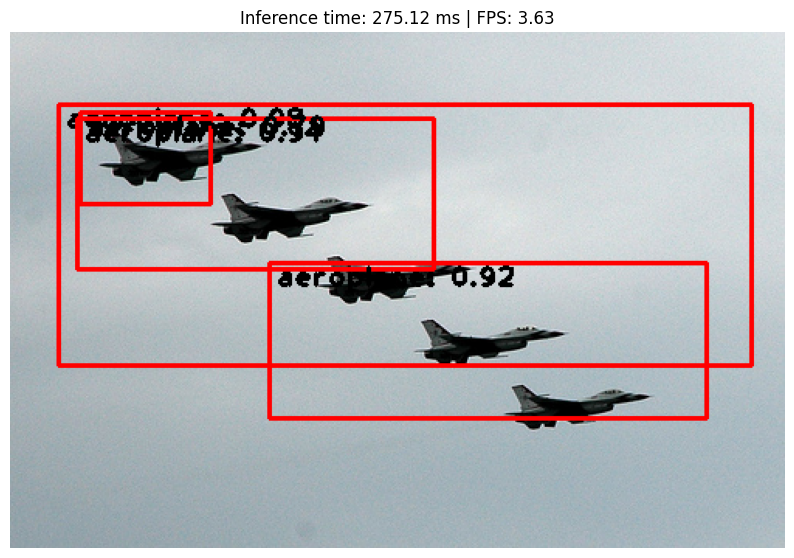

In [90]:
img_name = "2008_008467.jpg"
image_path = f"{BASE_PATH}\\{img_name}"

visualize_single_image(image_path)

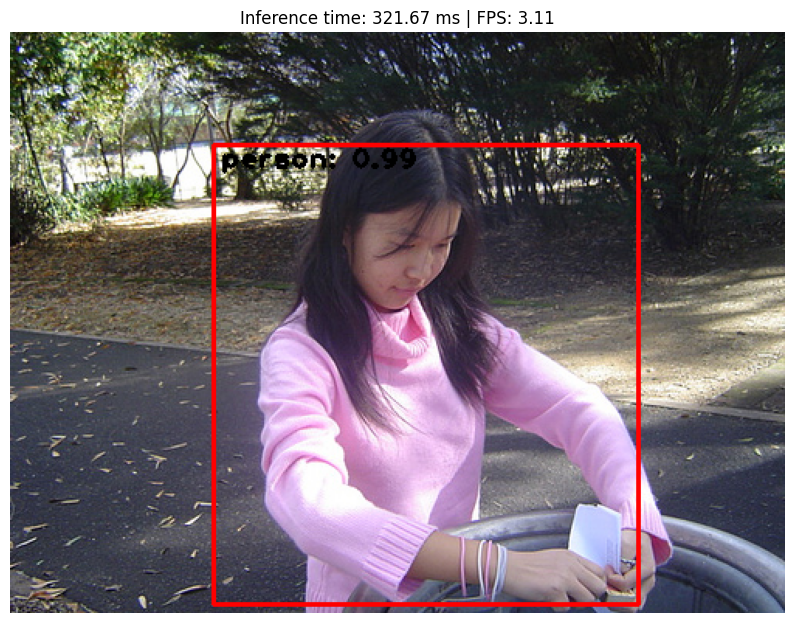

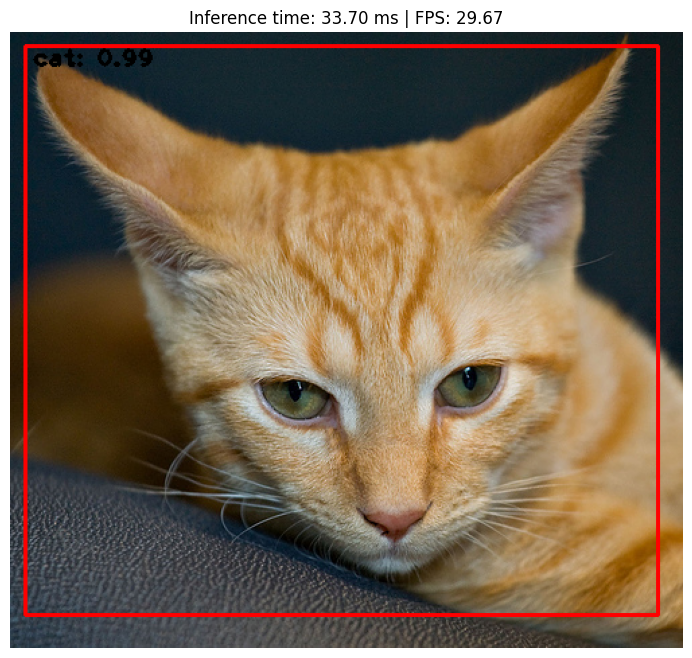

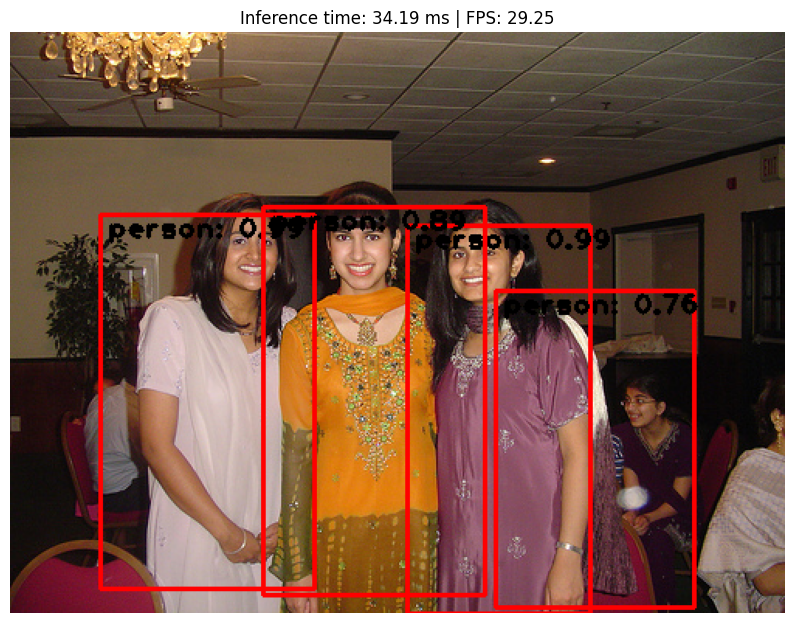

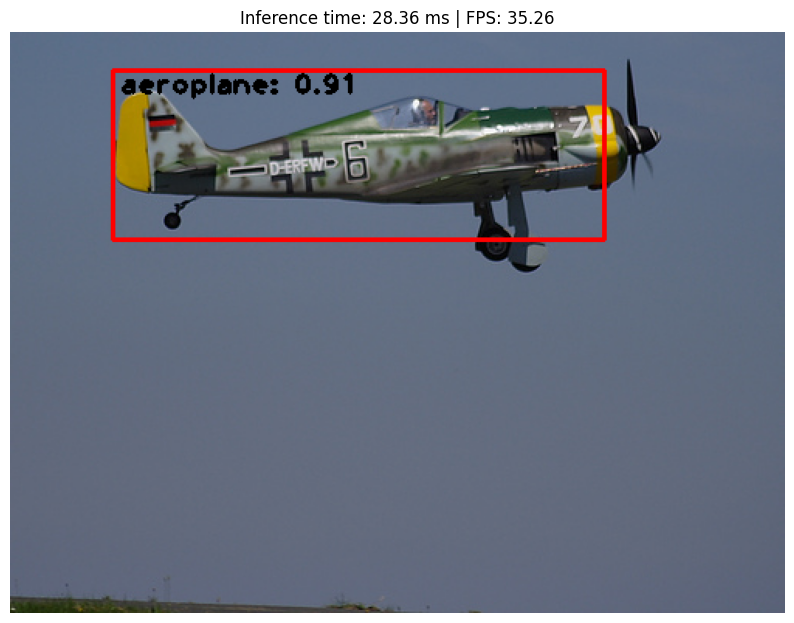

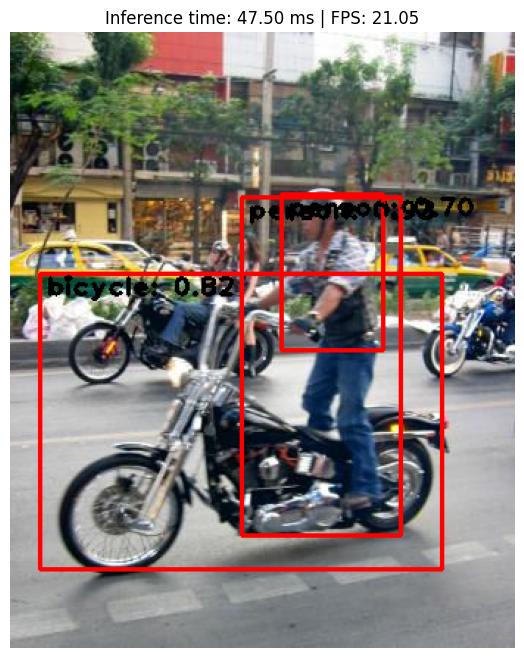

In [91]:
for img_name in ["2008_000406.jpg", "2008_000536.jpg", "2008_000976.jpg", "2008_001380.jpg", "2008_005245.jpg"]:
    image_path = f"{BASE_PATH}\\{img_name}"
    visualize_single_image(image_path)